In [1]:
include("diffusion.jl")

interp_vals (generic function with 1 method)

## Define dynamical system generators

In [2]:
Δx = 0.1
h  = 0.01
δ  = 0.1
δ1  = 0.5
v_x = 0

α=(1/2)*δ*h/(Δx^2)
α1=(1/2)*δ1*h/(Δx^2)
β=(1/4)*v_x*h/(Δx)

gen = Dict(
    :diffuse => u -> u+[(u[5]-u[1]*(1-β/α))*α,
                         (u[5]-u[2])*α,
                         (u[5]-u[3]*(1+β/α))*α,
                         (u[5]-u[4])*α,
                         (u[1]*(1-β/α) + u[2] + u[3]*(1+β/α) + u[4] - 4*u[5])*α],
    :diffuse2 => u -> u+[(u[5]-u[1]*(1-β/α1))*α1,
                         (u[5]-u[2])*α1,
                         (u[5]-u[3]*(1+β/α1))*α1,
                         (u[5]-u[4])*α1,
                         (u[1]*(1-β/α1) + u[2] + u[3]*(1+β/α1) + u[4] - 4*u[5])*α1]
)

# Turn generators into Open Dynam objects
diffuse = Open(Dynam(gen[:diffuse], 5, [1,2,3,4], [0,0,0,0,0]))
diffuse2 = Open(Dynam(gen[:diffuse2], 5, [1,2,3,4], [0,0,0,0,0]));

## Define the relationships for homogenous and heterogenous (checkerboarded) systems

In [3]:
#    n1   n2
#    |    |
# w1-d1-n-d2-e1
#    |    |
#    w    e
#    |    |
# w2-d3-s-d4-e2
#    |    |
#    s1   s2
quad_hom = @relation (e1, e2, n1, n2, w1, w2, s1, s2) where (e1, e2, n1, n2, w1, w2, s1, s2, e, n, w, s) begin
    diffuse(n, n1, w1, w)
    diffuse(e1, n2, n, e)
    diffuse(s, w, w2, s1)
    diffuse(e2, e, s, s2)
end

quad_het = @relation (e1, e2, n1, n2, w1, w2, s1, s2) where (e1, e2, n1, n2, w1, w2, s1, s2, e, n, w, s) begin
    diffuse_m1(n, n1, w1, w)
    diffuse_m2(e1, n2, n, e)
    diffuse_m2(s, w, w2, s1)
    diffuse_m1(e2, e, s, s2)
end;

## Construct material simulations

In [4]:
# Homogenous 16x16 system of material 1
diff_2x2_1 = functor(quad_hom, Dict(:diffuse=>diffuse), bundling=[[1,2],[3,4],[5,6],[7,8]]);
diff_4x4_1 = functor(quad_hom, Dict(:diffuse=>diff_2x2_1), bundling=[[1,2],[3,4],[5,6],[7,8]]);
diff_8x8_1 = functor(quad_hom, Dict(:diffuse=>diff_4x4_1), bundling=[[1,2],[3,4],[5,6],[7,8]]);
diff_16x16_1 = functor(quad_hom, Dict(:diffuse=>diff_8x8_1), bundling=[[1,2],[3,4],[5,6],[7,8]]);

# Homogenous 16x16 system of material 2
diff_2x2_2 = functor(quad_hom, Dict(:diffuse=>diffuse2), bundling=[[1,2],[3,4],[5,6],[7,8]]);
diff_4x4_2 = functor(quad_hom, Dict(:diffuse=>diff_2x2_2), bundling=[[1,2],[3,4],[5,6],[7,8]]);
diff_8x8_2 = functor(quad_hom, Dict(:diffuse=>diff_4x4_2), bundling=[[1,2],[3,4],[5,6],[7,8]]);
diff_16x16_2 = functor(quad_hom, Dict(:diffuse=>diff_8x8_2), bundling=[[1,2],[3,4],[5,6],[7,8]]);

# Heterogenous 32x32 system of material 1 and material 2 in checkerboard pattern
diff_32x32 = functor(quad_het,
                     Dict(:diffuse_m1=>diff_16x16_1, :diffuse_m2=>diff_16x16_2),
                     bundling=[[1,2],[3,4],[5,6],[7,8]]);

## Render 4x4 system

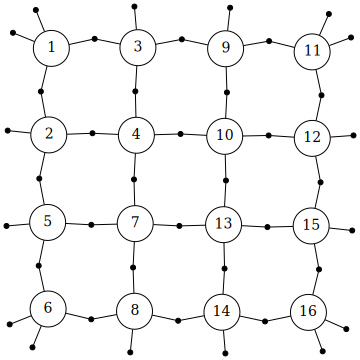

In [5]:
draw_dynam(diff_4x4_1.cospan.apex, box_labels=true)

## Execute Simulation

In [9]:
state,coords = initialize_dot([0.5, 0.5],[0.1, 0.1], 5);
init = copy(state)
res = zeros(length(state))
anim = @animate for i ∈ 1:200
    time_index = i*h
    update!(res, diff_32x32.cospan.apex, state);
    state = copy(res);
    contour(1:size(coords,1), 1:size(coords,2), transpose(state[coords]), title="t=$(((time_index*100)÷10)/10)", aspect_ratio=1, clims=(0,maximum(init)), fill=true, color=:blues)
    #heatmap(1:size(coords,1), 1:size(coords,2), transpose(state[coords]), title="t=$(((time_index*100)÷10)/10)", aspect_ratio=1, clims=(0,maximum(init)), color=:blues)
end;


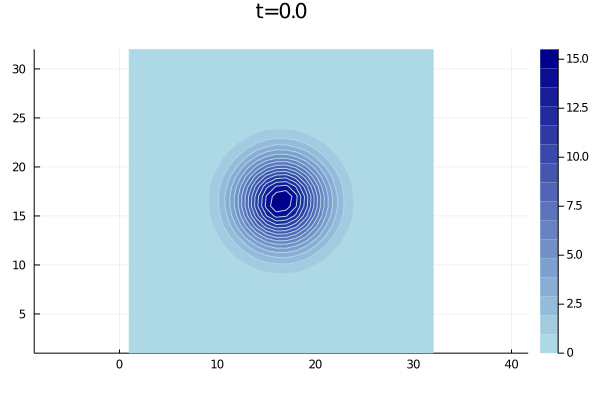

In [10]:
gif(anim, "test.gif")